# Lab 02a: PyTorch Lightning

### What You Will Learn

- The core components of a PyTorch Lightning training loop: `LightningModule`s and `Trainer`s.
- Useful quality-of-life improvements offered by PyTorch Lightning: `LightningDataModule`s, `Callback`s, and `Metric`s
- How we use these features in the FSDL codebase

## Setup

In [5]:
if "bootstrap" not in locals() or bootstrap.run:
    # path management for Python
    pythonpath, = !echo $PYTHONPATH
    if "." not in pythonpath.split(":"):
        pythonpath = ".:" + pythonpath
        %env PYTHONPATH={pythonpath}
        !echo $PYTHONPATH

    # get both Colab and local notebooks into the same state
    !wget --quiet https://fsdl.me/gist-bootstrap -O bootstrap.py
    import bootstrap

    # change into the lab directory
    # bootstrap.change_to_lab_dir(lab_idx=lab_idx)

    # allow "hot-reloading" of modules
    %load_ext autoreload
    %autoreload 2
    # needed for inline plots in some contexts
    %matplotlib inline

    bootstrap.run = False  # change to True re-run setup
    
!pwd
%ls

/home/amazingguni/git/fsdl-text-recognizer-2022-labs
Makefile   data/            notebooks/     text_recognizer/
README.md  environment.yml  requirements/


## Why Lighting

In [6]:
import pytorch_lightning as pl

version = pl.__version__

docs_url = f"https://pytorch-lightning.readthedocs.io/en/{version}/"  # version can also be latest, stable
docs_url

'https://pytorch-lightning.readthedocs.io/en/1.6.3/'

In [7]:
import IPython.display as display


display.IFrame(src="https://pl-bolts-doc-images.s3.us-east-2.amazonaws.com/pl_docs/pl_mod_vid.m4v",
               width=720, height=720)

## The `pl.LightningModule`

In [8]:
import torch

issubclass(pl.LightningModule, torch.nn.Module)

True

In [9]:
from text_recognizer.lit_models import BaseLitModel

In [10]:
class LinearRegression(pl.LightningModule):

    def __init__(self):
        super().__init__()  # just like in torch.nn.Module, we need to call the parent class __init__

        # attach torch.nn.Modules as top level attributes during init, just like in a torch.nn.Module
        self.model = torch.nn.Linear(in_features=1, out_features=1)
        # we like to define the entire model as one torch.nn.Module -- typically in a separate class

    # optionally, define a forward method
    def forward(self, xs):
        return self.model(xs)  # we like to just call the model's forward method

In [11]:
import logging  # import some stdlib components to control what's display
import textwrap
import traceback


try:  # try using the LinearRegression LightningModule defined above
    logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)  # hide some info for now

    model = LinearRegression()

    # we'll explain how the Trainer works in a bit
    trainer = pl.Trainer(gpus=int(torch.cuda.is_available()), max_epochs=1)
    trainer.fit(model=model)  

except pl.utilities.exceptions.MisconfigurationException as error:
    print("Error:", *textwrap.wrap(str(error), 80), sep="\n\t")  # show the error without raising it

finally:  # bring back info-level logging
    logging.getLogger("pytorch_lightning").setLevel(logging.INFO)

Error:
	No `training_step()` method defined. Lightning `Trainer` expects as minimum a
	`training_step()`, `train_dataloader()` and `configure_optimizers()` to be
	defined.


In [12]:
from typing import Tuple

def training_step(self: pl.LightningModule, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> torch.Tensor:
    xs, ys = batch
    outs = self(xs)
    loss = torch.nn.functional.mse_loss(outs, ys)
    return loss

LinearRegression.training_step = training_step

In [13]:
BaseLitModel.training_step??

Signature: BaseLitModel.training_step(self, batch, batch_idx)
Docstring:
Here you compute and return the training loss and some additional metrics for e.g.
the progress bar or logger.

Args:
    batch (:class:`~torch.Tensor` | (:class:`~torch.Tensor`, ...) | [:class:`~torch.Tensor`, ...]):
        The output of your :class:`~torch.utils.data.DataLoader`. A tensor, tuple or list.
    batch_idx (``int``): Integer displaying index of this batch
    optimizer_idx (``int``): When using multiple optimizers, this argument will also be present.
    hiddens (``Any``): Passed in if
        :paramref:`~pytorch_lightning.core.lightning.LightningModule.truncated_bptt_steps` > 0.

Return:
    Any of.

    - :class:`~torch.Tensor` - The loss tensor
    - ``dict`` - A dictionary. Can include any keys, but must include the key ``'loss'``
    - ``None`` - Training will skip to the next batch. This is only for automatic optimization.
        This is not supported for multi-GPU, TPU, IPU, or DeepSpeed.

I

In [14]:
def configure_optimizers(self: LinearRegression) -> torch.optim.Optimizer:
    optimizer = torch.optim.Adam(self.parameters(), lr=3e-4)
    return optimizer

LinearRegression.configure_optimizers = configure_optimizers

In [15]:
BaseLitModel.configure_optimizers??

Signature: BaseLitModel.configure_optimizers(self)
Docstring:
Choose what optimizers and learning-rate schedulers to use in your optimization.
Normally you'd need one. But in the case of GANs or similar you might have multiple.

Return:
    Any of these 6 options.

    - **Single optimizer**.
    - **List or Tuple** of optimizers.
    - **Two lists** - The first list has multiple optimizers, and the second has multiple LR schedulers
      (or multiple ``lr_scheduler_config``).
    - **Dictionary**, with an ``"optimizer"`` key, and (optionally) a ``"lr_scheduler"``
      key whose value is a single LR scheduler or ``lr_scheduler_config``.
    - **Tuple of dictionaries** as described above, with an optional ``"frequency"`` key.
    - **None** - Fit will run without any optimizer.

The ``lr_scheduler_config`` is a dictionary which contains the scheduler and its associated configuration.
The default configuration is shown below.

.. code-block:: python

    lr_scheduler_config = {
        

## The `pl.Traininer`

In [16]:
trainer = pl.Trainer(max_epochs=20, gpus=int(torch.cuda.is_available()))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [17]:
class CorrelatedDataset(torch.utils.data.Dataset):
    def __init__(self, N=10_000):
        self.N = N
        self.xs = torch.randn(size=(N, 1))
        self.ys = torch.randn_like(self.xs) + self.xs
    
    def __getitem__(self, idx):
        return (self.xs[idx], self.ys[idx])

    def __len__(self):
        return self.N

dataset = CorrelatedDataset()
tdl = torch.utils.data.DataLoader(dataset, batch_size=32, num_workers=1)

In [18]:
example_xs, example_ys = next(iter(tdl))  # grabbing an example batch to print

print("xs:", example_xs[:10], sep="\n")
print("ys:", example_ys[:10], sep="\n")

xs:
tensor([[ 0.7219],
        [ 0.4690],
        [-0.1064],
        [ 0.4239],
        [ 0.8937],
        [-0.0726],
        [-0.1596],
        [ 0.0636],
        [ 0.1788],
        [ 0.2255]])
ys:
tensor([[ 0.2742],
        [ 1.6060],
        [ 0.1574],
        [ 0.8369],
        [-0.6390],
        [-0.9463],
        [-0.3240],
        [ 1.5056],
        [-1.4219],
        [ 2.0510]])


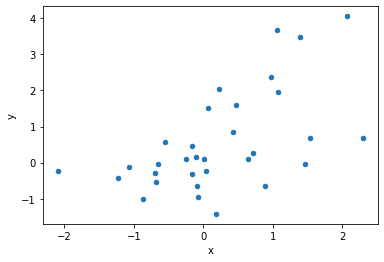

In [19]:
import pandas as pd


pd.DataFrame(data={"x": example_xs.flatten(), "y": example_ys.flatten()})\
  .plot(x="x", y="y", kind="scatter");

In [20]:
model = LinearRegression()

print("loss before training:", torch.mean(torch.square(model(dataset.xs) - dataset.ys)).item())

trainer.fit(model=model, train_dataloaders=tdl)

print("loss after training:", torch.mean(torch.square(model(dataset.xs) - dataset.ys)).item())

Missing logger folder: /home/amazingguni/git/fsdl-text-recognizer-2022-labs/lightning_logs


loss before training: 5.474055290222168


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | Linear | 2     
---------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)
/home/amazingguni/miniconda3/envs/fsdl-text-recognizer-2022/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

loss after training: 1.2302863597869873


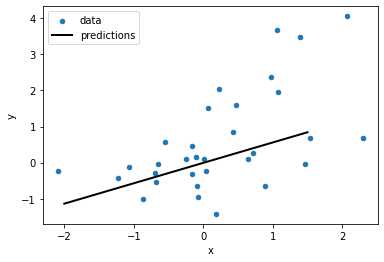

In [21]:
ax = pd.DataFrame(data={"x": example_xs.flatten(), "y": example_ys.flatten()})\
  .plot(x="x", y="y", legend=True, kind="scatter", label="data")

inps = torch.arange(-2, 2, 0.5)[:, None]
ax.plot(inps, model(inps).detach(), lw=2, color="k", label="predictions"); ax.legend();

In [22]:
pl.Trainer.__init__.__doc__.strip().split("\n")[0]

'Customize every aspect of training via flags.'

In [23]:
print(pl.Trainer.__init__.__doc__)


        Customize every aspect of training via flags.

        Args:

            accelerator: Supports passing different accelerator types ("cpu", "gpu", "tpu", "ipu", "hpu", "auto")
                as well as custom accelerator instances.

                .. deprecated:: v1.5
                    Passing training strategies (e.g., 'ddp') to ``accelerator`` has been deprecated in v1.5.0
                    and will be removed in v1.7.0. Please use the ``strategy`` argument instead.

            accumulate_grad_batches: Accumulates grads every k batches or as set up in the dict.
                Default: ``None``.

            amp_backend: The mixed precision backend to use ("native" or "apex").
                Default: ``'native''``.

            amp_level: The optimization level to use (O1, O2, etc...). By default it will be set to "O2"
                if ``amp_backend`` is set to "apex".

            auto_lr_find: If set to True, will make trainer.tune() run a learning rate finder,
 

## Training with PyTorch Lightning in the FSDL Codebase

In [24]:
!ls text_recognizer/lit_models

__init__.py  __pycache__  base.py


In [26]:
!ls training

__init__.py  __pycache__  run_experiment.py  util.py


In [27]:
import training.run_experiment


print(training.run_experiment.__doc__, training.run_experiment.main.__doc__)

Experiment-running framework. 
    Run an experiment.

    Sample command:
    ```
    python training/run_experiment.py --max_epochs=3 --gpus='0,' --num_workers=20 --model_class=MLP --data_class=MNIST
    ```

    For basic help documentation, run the command
    ```
    python training/run_experiment.py --help
    ```

    The available command line args differ depending on some of the arguments, including --model_class and --data_class.

    To see which command line args are available and read their documentation, provide values for those arguments
    before invoking --help, like so:
    ```
    python training/run_experiment.py --model_class=MLP --data_class=MNIST --help
    


In [28]:
# how the trainer is initialized in the training script
!grep "pl.Trainer.from" training/run_experiment.py

    trainer = pl.Trainer.from_argparse_args(args, callbacks=callbacks, logger=logger)


In [29]:
# displays the first few flags for controlling the Trainer from the command line
!python training/run_experiment.py --help | grep "pl.Trainer" -A 24

pl.Trainer:
  --logger [LOGGER]     Logger (or iterable collection of loggers) for
                        experiment tracking. A ``True`` value uses the default
                        ``TensorBoardLogger``. ``False`` will disable logging.
                        If multiple loggers are provided and the `save_dir`
                        property of that logger is not set, local files
                        (checkpoints, profiler traces, etc.) are saved in
                        ``default_root_dir`` rather than in the ``log_dir`` of
                        any of the individual loggers. Default: ``True``.
  --checkpoint_callback [CHECKPOINT_CALLBACK]
                        If ``True``, enable checkpointing. Default: ``None``.
                        .. deprecated:: v1.5 ``checkpoint_callback`` has been
                        deprecated in v1.5 and will be removed in v1.7. Please
                        consider using ``enable_checkpointing`` instead.
  --enable_checkpointing [ENAB

# Extra Goodies

We'll cover three more here:
- `pl.LightningDataModule`s, for organizing dataloaders and handling data in distributed settings
- `pl.Callback`s, for adding "optional" extra features to model training
- `torchmetrics`, for efficiently computing and logging 

## `pl.LightningDataModule`

In [38]:
import math

class CorrelatedDataModule(pl.LightningDataModule):
    def __init__(self, size=10_000, train_frac=0.8, batch_size=32):
        super().__init__()
        self.size = size
        self.train_frac, self.val_frac = train_frac, 1-train_frac
        self.train_indices = list(range(math.floor(self.size * train_frac)))
        self.val_indices = list(range(self.train_indices[-1], self.size))
        self.dataset = CorrelatedDataset(N=size)

In [39]:
def setup(self, stage=None):  # prepares state that needs to be set for each GPU on each node
    if stage == "fit" or stage is None:  # other stages: "test", "predict"
        self.train_dataset = torch.utils.data.Subset(self.dataset, self.train_indices)
        self.val_dataset = torch.utils.data.Subset(self.dataset, self.val_indices)

def prepare_data(self):  # prepares state that needs to be set once per node
    pass  # but we don't have any "node-level" computations


CorrelatedDataModule.setup, CorrelatedDataModule.prepare_data = setup, prepare_data

In [40]:
def train_dataloader(self: pl.LightningDataModule) -> torch.utils.data.DataLoader:
    return torch.utils.data.DataLoader(self.train_dataset, batch_size=32)

def val_dataloader(self: pl.LightningDataModule) -> torch.utils.data.DataLoader:
    return torch.utils.data.DataLoader(self.val_dataset, batch_size=32)


CorrelatedDataModule.train_dataloader, CorrelatedDataModule.val_dataloader = train_dataloader, val_dataloader

In [41]:
model = LinearRegression()
datamodule = CorrelatedDataModule()
dataset = datamodule.dataset

print("loss before training:", torch.mean(torch.square(model(dataset.xs) - dataset.ys)).item())

trainer = pl.Trainer(max_epochs=10, gpus=int(torch.cuda.is_available()))
trainer.fit(model=model, datamodule=datamodule)

print("loss after training:", torch.mean(torch.square(model(dataset.xs) - dataset.ys)).item())

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/amazingguni/miniconda3/envs/fsdl-text-recognizer-2022/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:131: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | Linear | 2     
---------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


loss before training: 4.887789726257324


/home/amazingguni/miniconda3/envs/fsdl-text-recognizer-2022/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

loss after training: 2.4029362201690674


## `pl.Callback`

In [43]:
hooks = ", ".join([method for method in dir(pl.Callback) if method.startswith("on_")])
print("hooks:", *textwrap.wrap(hooks, width=80), sep="\n\t")

hooks:
	on_after_backward, on_batch_end, on_batch_start,
	on_before_accelerator_backend_setup, on_before_backward,
	on_before_optimizer_step, on_before_zero_grad, on_configure_sharded_model,
	on_epoch_end, on_epoch_start, on_exception, on_fit_end, on_fit_start,
	on_init_end, on_init_start, on_keyboard_interrupt, on_load_checkpoint,
	on_predict_batch_end, on_predict_batch_start, on_predict_end,
	on_predict_epoch_end, on_predict_epoch_start, on_predict_start,
	on_pretrain_routine_end, on_pretrain_routine_start, on_sanity_check_end,
	on_sanity_check_start, on_save_checkpoint, on_test_batch_end,
	on_test_batch_start, on_test_end, on_test_epoch_end, on_test_epoch_start,
	on_test_start, on_train_batch_end, on_train_batch_start, on_train_end,
	on_train_epoch_end, on_train_epoch_start, on_train_start,
	on_validation_batch_end, on_validation_batch_start, on_validation_end,
	on_validation_epoch_end, on_validation_epoch_start, on_validation_start


In [44]:
class HelloWorldCallback(pl.Callback):

    def on_train_epoch_start(self, trainer: pl.Trainer, pl_module: pl.LightningModule):
        print("👋 hello from the start of the training epoch!")

    def on_validation_epoch_end(self, trainer: pl.Trainer, pl_module: pl.LightningModule):
        print("👋 hello from the end of the validation epoch!")

In [45]:
import random


def on_train_batch_start(self, trainer: pl.Trainer, pl_module: pl.LightningModule, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int):
        if random.random() > 0.995:
            print(f"👋 hello from inside the lucky batch, #{batch_idx}!")


HelloWorldCallback.on_train_batch_start = on_train_batch_start

In [46]:
model = LinearRegression()

datamodule = CorrelatedDataModule()

trainer = pl.Trainer(  # we instantiate and provide the callback here, but nothing happens yet
    max_epochs=10, gpus=int(torch.cuda.is_available()), callbacks=[HelloWorldCallback()])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [47]:
trainer.fit(model=model, datamodule=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | Linear | 2     
---------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

👋 hello from the start of the training epoch!
👋 hello from inside the lucky batch, #14!
👋 hello from the start of the training epoch!
👋 hello from the start of the training epoch!
👋 hello from inside the lucky batch, #19!
👋 hello from inside the lucky batch, #105!
👋 hello from the start of the training epoch!
👋 hello from inside the lucky batch, #54!
👋 hello from inside the lucky batch, #102!
👋 hello from inside the lucky batch, #206!
👋 hello from the start of the training epoch!
👋 hello from inside the lucky batch, #149!
👋 hello from inside the lucky batch, #217!
👋 hello from inside the lucky batch, #237!
👋 hello from the start of the training epoch!
👋 hello from the start of the training epoch!
👋 hello from inside the lucky batch, #132!
👋 hello from inside the lucky batch, #155!
👋 hello from inside the lucky batch, #202!
👋 hello from inside the lucky batch, #223!
👋 hello from the start of the training epoch!
👋 hello from the start of the training epoch!
👋 hello from inside the lucky 

## `torchmetric`

In [48]:
import torchmetrics


tm_version = torchmetrics.__version__
print("metrics:", *textwrap.wrap(", ".join(torchmetrics.__all__), width=80), sep="\n\t")

metrics:
	functional, Accuracy, AUC, AUROC, AveragePrecision, BinnedAveragePrecision,
	BinnedPrecisionRecallCurve, BinnedRecallAtFixedPrecision, BLEUScore,
	BootStrapper, CalibrationError, CatMetric, CHRFScore, CohenKappa,
	ConfusionMatrix, CosineSimilarity, TweedieDevianceScore, ExplainedVariance,
	ExtendedEditDistance, F1, F1Score, FBeta, FBetaScore, HammingDistance, Hinge,
	HingeLoss, JaccardIndex, KLDivergence, MatthewsCorrcoef, MatthewsCorrCoef,
	MaxMetric, MeanAbsoluteError, MeanAbsolutePercentageError, MeanMetric,
	MeanSquaredError, MeanSquaredLogError, Metric, MetricCollection, MetricTracker,
	MinMaxMetric, MinMetric, MultioutputWrapper,
	MultiScaleStructuralSimilarityIndexMeasure, PearsonCorrcoef, PearsonCorrCoef,
	PermutationInvariantTraining, PIT, Precision, PrecisionRecallCurve, PSNR,
	PeakSignalNoiseRatio, R2Score, Recall, RetrievalFallOut, RetrievalHitRate,
	RetrievalMAP, RetrievalMRR, RetrievalNormalizedDCG, RetrievalPrecision,
	RetrievalRecall, RetrievalRPrecision, ROC,

In [49]:
issubclass(torchmetrics.Metric, torch.nn.Module)

True

In [50]:
BaseLitModel.__init__??

Signature: BaseLitModel.__init__(self, model, args: argparse.Namespace = None)
Docstring: Initialize self.  See help(type(self)) for accurate signature.
Source:   
    def __init__(self, model, args: argparse.Namespace = None):
        super().__init__()
        self.model = model
        self.args = vars(args) if args is not None else {}

        self.data_config = self.model.data_config
        self.mapping = self.data_config["mapping"]
        self.input_dims = self.data_config["input_dims"]

        optimizer = self.args.get("optimizer", OPTIMIZER)
        self.optimizer_class = getattr(torch.optim, optimizer)

        self.lr = self.args.get("lr", LR)

        loss = self.args.get("loss", LOSS)
        if loss not in ("transformer",):
            self.loss_fn = getattr(torch.nn.functional, loss)

        self.one_cycle_max_lr = self.args.get("one_cycle_max_lr", None)
        self.one_cycle_total_steps = self.args.get("one_cycle_total_steps", ONE_CYCLE_TOTAL_STEPS)

        self.tr

In [65]:
from typing import Tuple

def validation_step(self: pl.LightningModule, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> torch.Tensor:
    xs, ys = batch
    outs = self(xs)
    loss = torch.nn.functional.mse_loss(outs, ys)
    self.log("validation/loss", loss, prog_bar=True, sync_dist=True)
    return {'loss': loss}
    

LinearRegression.validation_step = validation_step

In [66]:
model = LinearRegression()
datamodule = CorrelatedDataModule()

dataset = datamodule.dataset

trainer = pl.Trainer(max_epochs=10, gpus=int(torch.cuda.is_available()))
# if you code is working, you should see results for the validation loss in the output
trainer.fit(model=model, datamodule=datamodule)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | Linear | 2     
---------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/amazingguni/miniconda3/envs/fsdl-text-recognizer-2022/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/amazingguni/miniconda3/envs/fsdl-text-recognizer-2022/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [56]:
def test_step(self: pl.LightningModule, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> torch.Tensor:
    xs, ys = batch
    outs = self(xs)
    loss = torch.nn.functional.mse_loss(outs, ys)
    self.log("test/loss", loss, on_step=False, on_epoch=True)

LinearRegression.test_step = test_step

In [57]:
class CorrelatedDataModuleWithTest(pl.LightningDataModule):

    def __init__(self, N=10_000, N_test=10_000):  # reimplement __init__ here
        super().__init__()  # don't forget this!
        self.dataset = None
        self.test_dataset = CorrelatedDataset(N=N_test)

    def setup(self, stage=None):
        pass

    def test_dataloader(self: pl.LightningDataModule) -> torch.utils.data.DataLoader:
        return torch.utils.data.DataLoader(self.test_dataset, batch_size=32)

In [58]:
model = LinearRegression()
datamodule = CorrelatedDataModuleWithTest()

dataset = datamodule.dataset

trainer = pl.Trainer(max_epochs=10, gpus=int(torch.cuda.is_available()))

# we run testing without fitting here
trainer.test(model=model, datamodule=datamodule)  # if your code is working, you should see performance on the test set here

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/loss           2.2911384105682373
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test/loss': 2.2911384105682373}]